In [322]:
import csv, datetime, json

nouns_bids = {}
nouns_auction_end_times = {}

with open('nouns_bids.csv', 'r') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)

  for row in reader:
    id = int(row[0])
    eth_price = int(row[2]) / 1e18
    timestamp = datetime.datetime.fromisoformat(row[7]).timestamp()

    if id in nouns_bids:
      nouns_bids[id]['eth_prices'].append(eth_price)
      nouns_bids[id]['timestamps'].append(timestamp)
    else:
      nouns_bids.update({
          id: {
              'eth_prices': [eth_price],
              'timestamps': [timestamp],
          }
      })

with open('nouns_auctions.csv', 'r') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)

  for row in reader:
    id = int(row[0])
    end_time = int(row[2])

    nouns_auction_end_times.update({id: end_time})

temp_nouns_bids = {}
normalized_nouns_bids = {}
price_contrib_freq = {i: [0 for _ in range(26)] for i in range(20)}
granular_price_contrib_freq = {i: [0 for _ in range(31)] for i in range(25)}

for id, noun in nouns_bids.items():
  timestamps = noun['timestamps']
  last_timestamp = timestamps[-1]
  eth_prices = noun['eth_prices']
  last_eth_price = eth_prices[-1]

  normalized_timestamps = [(timestamp - last_timestamp) / 3600 for timestamp in timestamps]
  normalized_eth_prices = [eth_price / last_eth_price for eth_price in eth_prices]

  temp_nouns_bids.update({
    id: {
      'timestamps': normalized_timestamps,
      'eth_prices': eth_prices,
    }
  })
  normalized_nouns_bids.update({
    id: {
      'timestamps': normalized_timestamps,
      'eth_prices': normalized_eth_prices,
    }
  })

  for timestamp, eth_price in zip(timestamps, normalized_eth_prices):
    normalized_timestamp = timestamp - max(nouns_auction_end_times[id], timestamps[-1])
    price_contrib_freq[int(eth_price // 0.05)][-int(normalized_timestamp / 3600)] += 1
    if normalized_timestamp >= -1_800:
      granular_price_contrib_freq[int(eth_price // 0.04)][-int(normalized_timestamp / 60)] += 1

nouns_bids = temp_nouns_bids

price_contrib_freq = [v for v in price_contrib_freq.values()]
granular_price_contrib_freq = [v for v in granular_price_contrib_freq.values()]

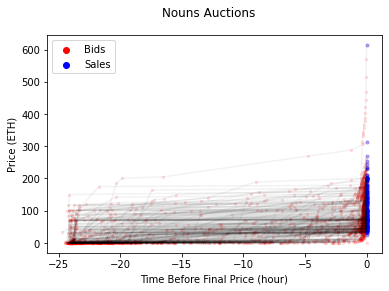

In [144]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

final_sales_timestamps = []
final_sales_prices = []

for id, noun in nouns_bids.items():
  timestamps = noun['timestamps']
  eth_prices = noun['eth_prices']
  last_eth_price = eth_prices[-1]

  final_sales_timestamps.append(0)
  final_sales_prices.append(last_eth_price)

  plt.plot(
    timestamps,
    eth_prices,
    color='black',
    alpha=0.05,
  )

  plt.scatter(
    timestamps,
    eth_prices,
    s=5,
    color='red',
    alpha=0.1,
  )

plt.scatter(
  final_sales_timestamps,
  final_sales_prices,
  s=10,
  color='blue',
  alpha=0.25,
)

plt.scatter([], [], color='red', label='Bids')
plt.scatter([], [], color='blue', label='Sales')

fig.suptitle('Nouns Auctions')
plt.ylabel('Price (ETH)')
plt.xlabel('Time Before Final Price (hour)')

ax.figure.set_facecolor('white')
ax.legend()

plt.show()

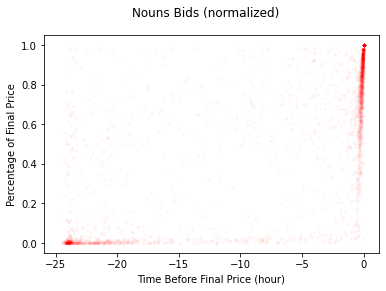

In [182]:
fig, ax = plt.subplots()

final_sales_timestamps = []
final_sales_prices = []

for id, noun in normalized_nouns_bids.items():
  timestamps = noun['timestamps']
  eth_prices = noun['eth_prices']
  last_eth_price = eth_prices[-1]

  final_sales_timestamps.append(0)
  final_sales_prices.append(last_eth_price)

  plt.scatter(
    timestamps,
    eth_prices,
    s=5,
    color='red',
    alpha=0.025,
  )

fig.suptitle('Nouns Bids (normalized)')
plt.ylabel('Percentage of Final Price')
plt.xlabel('Time Before Final Price (hour)')

ax.figure.set_facecolor('white')

plt.show()

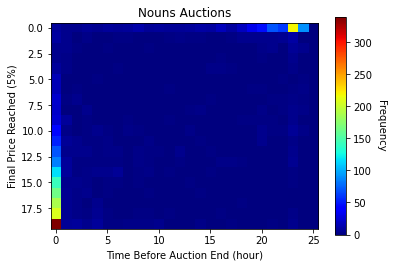

In [324]:
fig, ax = plt.subplots()

im = ax.imshow(price_contrib_freq, cmap='jet')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Frequency', rotation=-90, va='bottom')

plt.ylabel('Final Price Reached (5%)')
plt.xlabel('Time Before Auction End (hour)')
ax.set_title('Nouns Auctions')

ax.figure.set_facecolor('white')

plt.show()

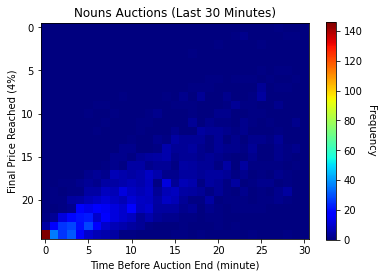

In [323]:
fig, ax = plt.subplots()

im = ax.imshow(granular_price_contrib_freq, cmap='jet')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Frequency', rotation=-90, va='bottom')

plt.ylabel('Final Price Reached (4%)')
plt.xlabel('Time Before Auction End (minute)')
ax.set_title('Nouns Auctions (Last 30 Minutes)')

ax.figure.set_facecolor('white')

plt.show()